# (29) Combine neural fits

**Motivation**: ...across different sim categories <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def best_results(df, categories: List[str] = None):
    if categories is None:
        categories = df['category'].unique()
    df_best = collections.defaultdict(list)
    for expt in df['expt'].unique():
        _df1 = df.loc[
            (df['expt'] == expt) &
            (df['category'].isin(categories))
        ]
        for cell in _df1['cell'].unique():
            _df2 = _df1.loc[_df1['cell'] == cell]
            best_i = _df2['perf'].argmax()
            best = dict(_df2.iloc[best_i])

            _max = best.pop('perf')
            _min = _df2['perf'].min()
            mu = _df2['perf'].mean()
            sd = _df2['perf'].std()

            best['perf_best'] = _max
            best['perf_worst'] = _min
            best['perf_mu'] = mu
            best['perf_sd'] = sd
            best['%+'] = 100 * (_max - mu) / mu
            best['%-'] = 100 * (_min - mu) / mu

            for k, v in best.items():
                df_best[k].append(v)
    df_best = pd.DataFrame(df_best)
    return df_best

## Copy fits to tmp dir

In [3]:
fits = [
    'fixate0_nf-80_(2023_04_28,22:46)',
    'fixate1_nf-420_(2023_04_27,20:20)',
    'fixate2_nf-420_(2023_04_27,13:57)',
    # 'fixate2_nf-420_(2023_04_28,12:46)', # local to GABAN, currently not used
    'fixate4_nf-420_(2023_04_28,16:15)',
    'fixate8_nf-420_(2023_04_28,14:34)',

    'transl0_nf-70_(2023_04_27,13:30)',
    'transl1_nf-420_(2023_04_27,13:00)',
    'transl2_nf-420_(2023_04_27,19:16)',
    'transl4_nf-420_(2023_04_27,07:52)',
    # TODO: transl8,
    
    'Medium_obj1_nf-280_(2023_04_26,15:53)',
    'obj4_nf-280_(2023_04_26,18:21)',
    'obj8_nf-420_(2023_04_28,12:48)',
    
    'terrain1_nf-210_(2023_04_27,12:50)',
    'terrain2_nf-420_(2023_04_28,15:15)',
    'terrain4_nf-420_(2023_04_28,14:08)',
    'terrain8_nf-420_(2023_04_26,22:51)',
]
copy_fits(fits, pjoin(tmp_dir, 'results_combined'))

## Load & analyze

In [4]:
df = []
perf = {}
for fit_name in fits:
    _df = f"summary_{fit_name}.df"
    _df = pjoin(tmp_dir, 'results_combined', _df)
    _df = pd.read_pickle(_df)
    k = _df['category'].unique().item()
    perf[k] = _df.perf.values
    df.append(_df)
df = pd.concat(df)
print({k: len(v) for k, v in perf.items()})

{
    'fixate0': 141,
    'fixate1': 141,
    'fixate2': 141,
    'fixate4': 141,
    'fixate8': 141,
    'transl0': 141,
    'transl1': 141,
    'transl2': 141,
    'transl4': 141,
    'obj1': 141,
    'obj4': 141,
    'obj8': 141,
    'terrain1': 141,
    'terrain2': 141,
    'terrain4': 141,
    'terrain8': 141
}

In [5]:
sorted_data = sorted(
    zip(*(v for v in perf.values())),
    key=lambda x: x[0],
)
sorted_data = tuple(zip(*sorted_data))

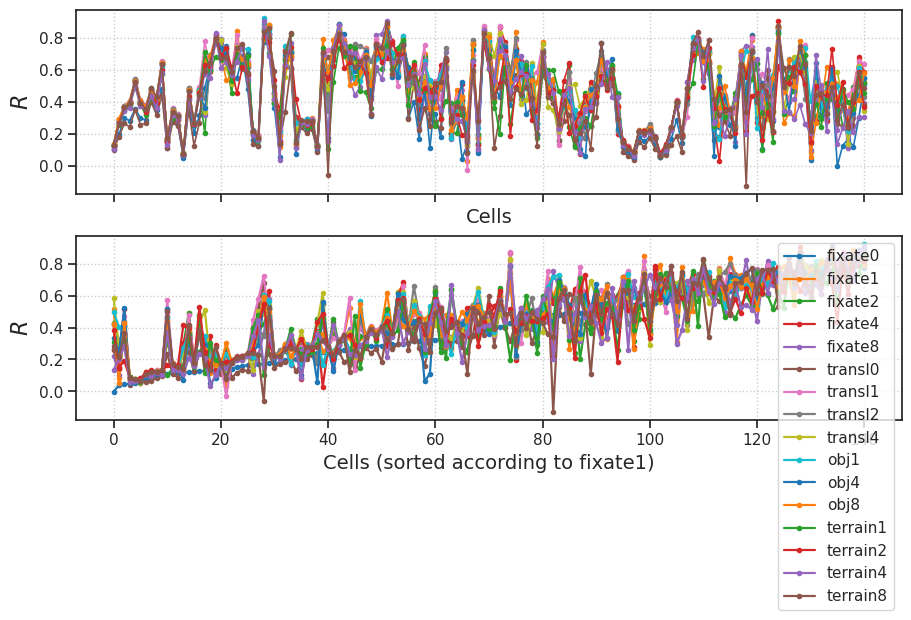

In [6]:
fig, axes = create_figure(2, 1, (9, 6), 'all', layout='constrained')

for k, v in perf.items():
    axes[0].plot(v, marker='.', lw=1.2, label=k)
axes[0].set_xlabel('Cells', fontsize=14)

for k, v in zip(perf, sorted_data):
    axes[1].plot(v, marker='.', lw=1.6, label=k)
axes[1].set_xlabel('Cells (sorted according to fixate1)', fontsize=14)
axes[1].legend()

for ax in axes.flat:
    ax.set_ylabel(r'$R$', fontsize=16)
    ax.grid()

plt.show()

In [7]:
x = np.stack([v for v in perf.values()])

counts = collections.Counter(np.argmax(x, axis=0))
counts = {
    list(perf)[i]: c for i, c
    in counts.most_common()
}
counts = {
    k: counts.get(k, 0) for k
    in list(counts) + list(perf)
}

percent = {
    k: np.round(100 * v / sum(counts.values()), 1)
    for k, v in counts.items()
}
print(percent)

{
    'transl1': 17.7,
    'fixate1': 12.8,
    'obj1': 8.5,
    'transl2': 7.8,
    'terrain2': 6.4,
    'transl4': 6.4,
    'fixate4': 6.4,
    'fixate8': 5.7,
    'terrain1': 5.7,
    'obj8': 5.0,
    'terrain8': 5.0,
    'terrain4': 3.5,
    'fixate2': 2.8,
    'fixate0': 2.1,
    'transl0': 2.1,
    'obj4': 2.1
}

In [8]:
best = x.max(0)
x = best.mean()
x

0.5692952952455489

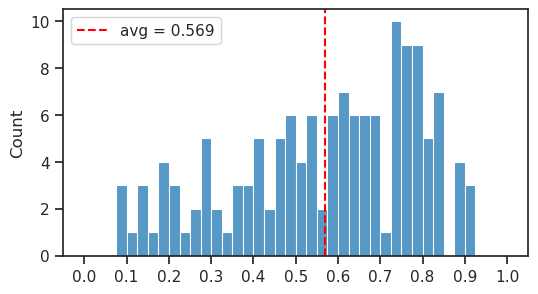

In [9]:
fig, ax = create_figure(1, 1, (6, 3.2))
sns.histplot(best, bins=np.linspace(0, 1, 41), ax=ax)
ax.axvline(x, color='r', ls='--', label=f"avg = {x:0.3f}")
ax.locator_params(axis='x', nbins=11)
ax.legend()
plt.show()

In [10]:
100 * (569 - 251) / 251

126.69322709163346

In [11]:
100 * (569 - 447) / 447

27.293064876957494

## More plots

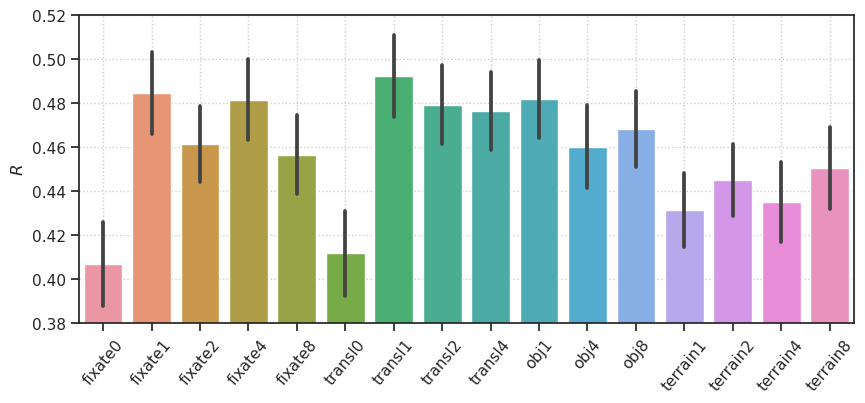

In [12]:
fig, ax = create_figure(1, 1, (10, 4))
sns.barplot(data=df, x='category', y='perf', errorbar='se', ax=ax)
ax.set(xlabel='', ylabel=r'$R$', ylim=(0.38, 0.52))
ax.tick_params(axis='x', rotation=50)
ax.grid()
plt.show()

## Get df best

In [13]:
df_best = best_results(df)
df_best

,category,nf,root,expt,cell,max_perf,log_alpha,best_lag,perf_best,perf_worst,perf_mu,perf_sd,%+,%-
0,obj1,280,YUWEI,clu036,0,NaN,5.0,5,0.136978,0.097910,0.123124,0.011844,11.252130,-20.478013
1,obj8,420,YUWEI,clu037,0,NaN,3.0,3,0.295114,0.182568,0.266937,0.032621,10.555650,-31.606246
2,fixate1,420,YUWEI,clu038,0,NaN,3.0,0,0.374930,0.264290,0.353931,0.030907,5.933044,-25.327267
3,transl1,420,YUWEI,clu039,0,NaN,3.0,1,0.407124,0.242731,0.377410,0.046727,7.872974,-35.685223
4,transl2,420,YUWEI,clu040,0,NaN,-10.0,3,0.542245,0.349288,0.504116,0.060809,7.563418,-30.712870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,terrain2,420,YUWEI,ytu029,19,0.941254,5.0,7,0.527142,0.125516,0.363444,0.104689,45.040946,-65.464717
137,transl1,420,YUWEI,ytu029,20,0.958395,3.0,5,0.444701,0.108589,0.262499,0.092507,69.410366,-58.632613
138,fixate2,420,YUWEI,ytu029,21,0.846710,-2.0,1,0.492103,0.119654,0.356652,0.101334,37.978601,-66.450803
139,fixate4,420,YUWEI,ytu029,22,0.930033,-2.0,2,0.683036,0.296732,0.533418,0.117780,28.048917,-44.371561


In [14]:
sorted_data = sorted(zip(
    df_best['perf_best'],
    df_best['perf_mu'],
    df_best['perf_sd'],
), key=lambda x: x[0])
sorted_data = list(map(
    lambda t: np.array(t),
    zip(*sorted_data),
))

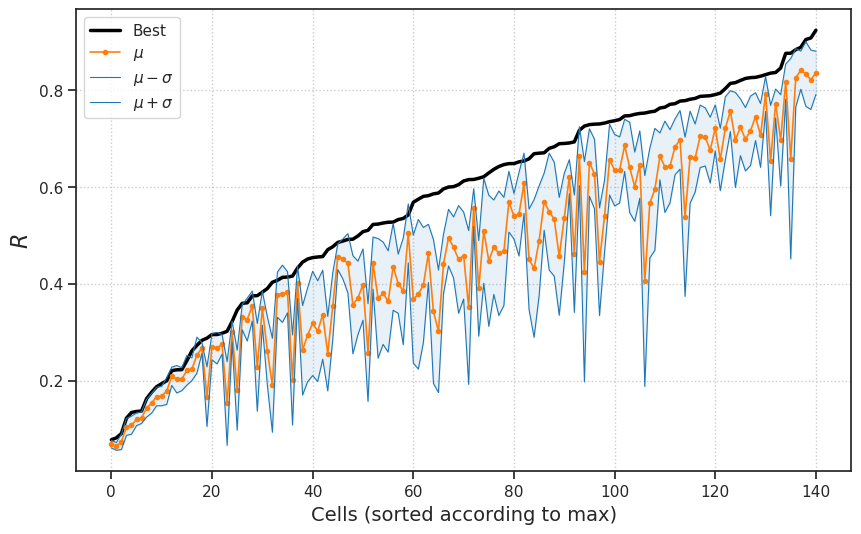

In [15]:
fig, ax = create_figure(1, 1, (10, 6))
ax.plot(sorted_data[0], lw=2.5, color='k', label='Best')
ax.plot(sorted_data[1], lw=1.2, color='C1', marker='.', label=r'$\mu$')

lower = sorted_data[1] - sorted_data[2]
higher = sorted_data[1] + sorted_data[2]
ax.plot(lower, lw=0.8, color='C0', label=r'$\mu - \sigma$')
ax.plot(higher, lw=0.8, color='C0', label=r'$\mu + \sigma$')
ax.fill_between(
    x=range(len(df_best)),
    y1=lower,
    y2=higher,
    color='C0',
    alpha=0.1,
)
ax.set_xlabel('Cells (sorted according to max)', fontsize=14)
ax.set_ylabel(r'$R$', fontsize=16)
ax.legend()
ax.grid()
plt.show()

In [16]:
inds = df_best['perf_best'].argsort()[::-1]
df_best.iloc[inds[:10]]

,category,nf,root,expt,cell,max_perf,log_alpha,best_lag,perf_best,perf_worst,perf_mu,perf_sd,%+,%-
28,obj1,280,YUWEI,clu116,0,0.835483,16.0,0,0.923867,0.775911,0.835795,0.044743,10.537471,-7.164903
51,fixate8,420,YUWEI,clu221,3,0.900849,1.0,5,0.907961,0.673433,0.821540,0.061376,10.519356,-18.028029
124,fixate4,420,YUWEI,ytu029,4,0.935583,-8.0,3,0.904700,0.626719,0.833401,0.066842,8.555122,-24.799876
42,obj4,280,YUWEI,clu209,1,0.923722,8.0,5,0.888635,0.734939,0.841380,0.039539,5.616330,-12.650734
29,transl4,420,YUWEI,clu120,0,0.967720,3.0,3,0.883813,0.689495,0.825567,0.060198,7.055267,-16.482183
72,transl1,420,YUWEI,clu267,7,0.955361,2.0,5,0.876347,0.196418,0.658305,0.207112,33.121789,-70.163001
69,transl1,420,YUWEI,clu267,4,0.979806,2.0,5,0.876143,0.754572,0.817686,0.036552,7.149049,-7.718602
23,fixate1,420,YUWEI,clu104,0,0.980831,0.0,4,0.845799,0.452378,0.696512,0.094309,21.433555,-35.050855
109,terrain8,420,YUWEI,clu295,4,0.929612,5.0,5,0.836597,0.708316,0.772484,0.029892,8.299607,-8.306712
75,fixate1,420,YUWEI,clu267,11,0.850368,-10.0,6,0.835265,0.478776,0.654688,0.113925,27.582144,-26.869576


### Pie chart

In [17]:
labels, vals = zip(*collections.Counter(
    df_best['category']).most_common())
vals = [100 * e / sum(vals) for e in vals]

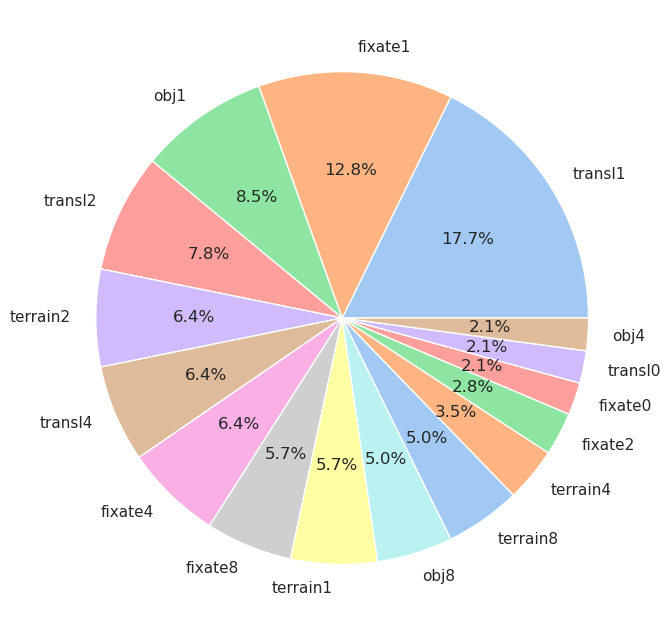

In [18]:
fig, ax = create_figure(1, 1, (10, 8))
ax.pie(
    x=vals,
    labels=labels,
    colors=sns.color_palette('pastel')[:len(labels)],
    autopct='%0.1f%%',
)
plt.show()

### Summary of results

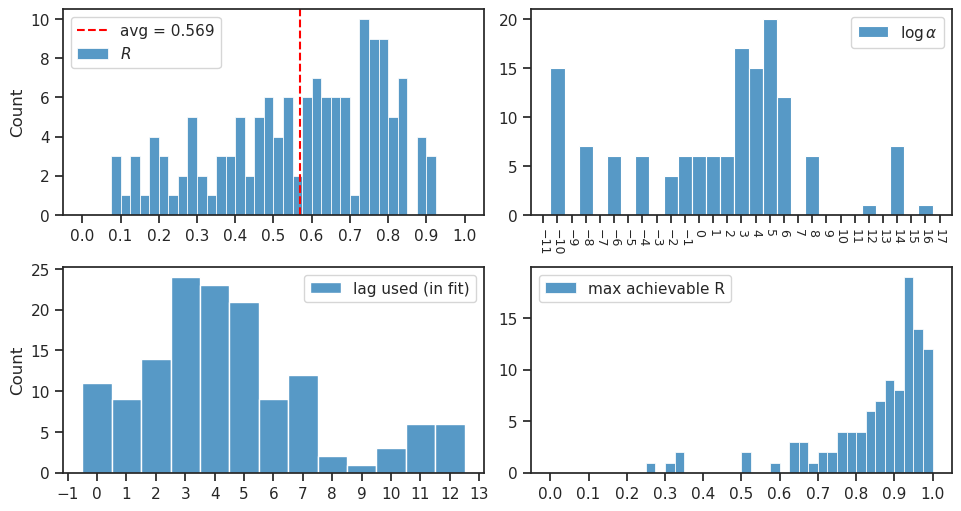

In [19]:
show_neural_results(df_best, 'perf_best');

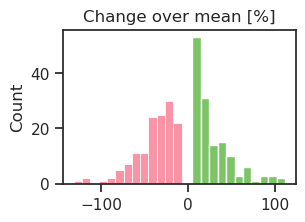

In [20]:
pal = sns.color_palette('husl')
pal = {'+': pal[2], '-': pal[0]}

fig, ax = create_figure(1, 1, (3, 2))
sns.histplot(df_best['%+'], color=pal['+'], ax=ax)
sns.histplot(df_best['%-'], color=pal['-'], ax=ax)
ax.set(xlabel='', title='Change over mean [%]')
plt.show()

In [21]:
val = np.concatenate([df_best['%+'].values, df_best['%-'].values])
label = ['+'] * len(df_best['%+']) + ['-'] * len(df_best['%-'])
# pal = sns.color_palette('pastel')
# pal = {'+': pal[2], '-': pal[3]}

# pal = sns.color_palette('husl')
# pal = {'+': pal[2], '-': pal[0]}

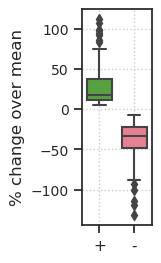

In [22]:
fig, ax = create_figure(1, 1, (0.9, 2.8))

sns.boxplot(
    data=pd.DataFrame({'val': val, 'label': label}),
    y='val',
    x='label',
    palette=pal,
    width=0.70,
    ax=ax,
)
ax.tick_params(axis='y', labelsize=10)
ax.set(xlabel='', ylabel='% change over mean')
ax.grid()
plt.show()

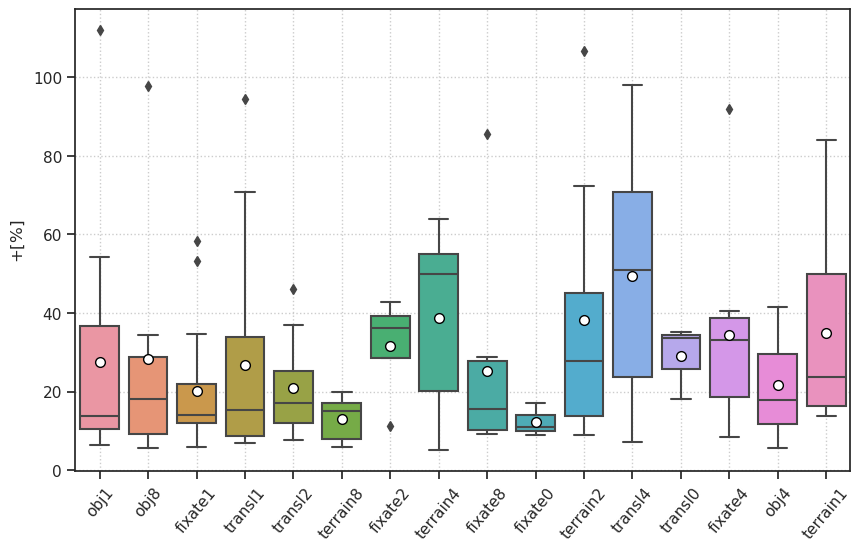

In [23]:
props_mean = {
    'marker': 'o',
    'markerfacecolor': 'white',
    'markeredgecolor': 'k',
    'markersize': 7,
    'alpha': 1.0,
}

fig, ax = create_figure(1, 1, (10, 6))
sns.boxplot(
    data=df_best,
    y='%+',
    x='category',
    hue='category',
    dodge=False,
    showmeans=True,
    meanprops=props_mean,
    ax=ax,
)
ax.set(xlabel='', ylabel=r'$+ [\%]$')
ax.tick_params(axis='x', rotation=50)
ax.get_legend().remove()
ax.grid()
plt.show()

In [24]:
categories = list(df['category'].unique())
df_test = best_results(df, categories)
perf_best = df_test['perf_best'].mean()
perf_best

0.569295295245549

In [41]:
reduced_perf = {}
for cat in ['fixate', 'transl', 'obj', 'terrain']:
    _df = best_results(df, [e for e in categories if cat not in e])
    reduced_perf[cat] = _df['perf_best'].mean()
print(reduced_perf)

{
    'fixate': 0.5608619058405487,
    'transl': 0.5573583165288217,
    'obj': 0.5662952427819891,
    'terrain': 0.560107695854514
}

In [42]:
reduced_perf_objs = {}
for n_obj in [0, 1, 2, 4, 8]:
    _df = best_results(df, [e for e in categories if int(e[-1]) == n_obj])
    reduced_perf_objs[n_obj] = _df['perf_best'].mean()
print(reduced_perf_objs)

{
    0: 0.44796809884141836,
    1: 0.5385817509997273,
    2: 0.5165595054286123,
    4: 0.5300833150368105,
    8: 0.5072535410862685
}

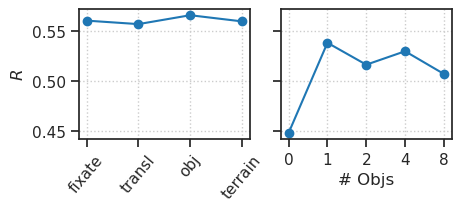

In [49]:
fig, axes = create_figure(1, 2, (4.5, 2), sharey='all', layout='constrained')

axes[0].plot(list(reduced_perf.values()), marker='o')
axes[0].set(xticks=range(len(reduced_perf)), xticklabels=list(reduced_perf), ylabel=r'$R$')
axes[0].tick_params(axis='x', rotation=50)
axes[0].grid()

axes[1].plot(list(reduced_perf_objs.values()), marker='o')
axes[1].set(xticks=range(len(reduced_perf_objs)), xticklabels=list(reduced_perf_objs), xlabel='# Objs')
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid()

plt.show()

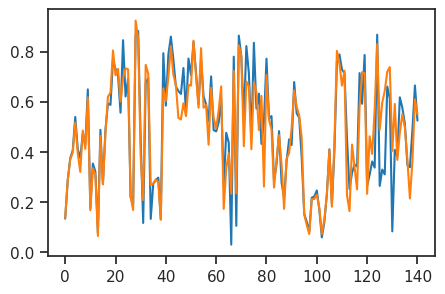

In [28]:
plt.plot(df.loc[df['category'] == 'fixate1', 'perf'].values)
plt.plot(df.loc[df['category'] == 'obj1', 'perf'].values)

## Permutation test

In [29]:
def statistic(a, b):
    return np.mean(a - b)

_data = (
    df.loc[df['category'] == 'fixate1', 'perf'].values,
    df.loc[df['category'] == 'fixate0', 'perf'].values,
)

test = sp_stats.permutation_test(
    data=_data,
    permutation_type='samples',
    statistic=statistic, 
    random_state=0,
)
print(f"p = {test.pvalue}")

p = 0.0002